In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at that file for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
mhd = MostHostsDesi()

[2021-10-26 10:56:18,560 - WARNING] - Building mosthosts_desi.csv from database.
[2021-10-26 10:56:19,519 - INFO] - Did 0 of 20174; 0 have at least 1 match
[2021-10-26 10:56:25,946 - INFO] - Did 1000 of 20174; 103 have at least 1 match
[2021-10-26 10:56:32,377 - INFO] - Did 2000 of 20174; 237 have at least 1 match
[2021-10-26 10:56:38,799 - INFO] - Did 3000 of 20174; 339 have at least 1 match
[2021-10-26 10:56:45,220 - INFO] - Did 4000 of 20174; 551 have at least 1 match
[2021-10-26 10:56:51,723 - INFO] - Did 5000 of 20174; 683 have at least 1 match
[2021-10-26 10:56:58,268 - INFO] - Did 6000 of 20174; 824 have at least 1 match
[2021-10-26 10:57:04,823 - INFO] - Did 7000 of 20174; 890 have at least 1 match
[2021-10-26 10:57:11,203 - INFO] - Did 8000 of 20174; 957 have at least 1 match
[2021-10-26 10:57:17,449 - INFO] - Did 9000 of 20174; 1029 have at least 1 match
[2021-10-26 10:57:23,978 - INFO] - Did 10000 of 20174; 1113 have at least 1 match
[2021-10-26 10:57:30,408 - INFO] - Did 11

In [3]:
# Print out some statistics
print( f'...as of when the csv file was last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{len(mhd.haszdf)} hosts have at least one DESI zwarn=0 redshift' )
hostcounts = mhd.haszdf.reset_index().groupby("snname")["snhostnum"].count().rename("n")
print( f'{len(hostcounts)} SNe/AGN have at least one host observed by DESI' )

print()
hostcounts = hostcounts.groupby(hostcounts).count()
for n, counts in hostcounts.iteritems():
    print( f'{counts:4d} SNe/AGN have {n:2d} hosts with at least one zwarn=0 DESI redshift' )

# Make a version omitting the QSOs
print()
justsne = mhd.haszdf[ mhd.haszdf['program'].apply( lambda x: 'QSO' not in x ) ]
hostcounts = justsne.reset_index().groupby("snname")["snhostnum"].count().rename("n")
print( f'{len(hostcounts)} different SNe have at least one DESI zwarn=0 redshift' )

print()
hostcounts = hostcounts.groupby(hostcounts).count()
for n, counts in hostcounts.iteritems():
    print( f'{counts:4d} SNe have {n:2d} hosts with at least one zwarn=0 DESI redshift' )

...as of when the csv file was last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
1850 hosts have at least one DESI zwarn=0 redshift
1791 SNe/AGN have at least one host observed by DESI

1739 SNe/AGN have  1 hosts with at least one zwarn=0 DESI redshift
  46 SNe/AGN have  2 hosts with at least one zwarn=0 DESI redshift
   5 SNe/AGN have  3 hosts with at least one zwarn=0 DESI redshift
   1 SNe/AGN have  4 hosts with at least one zwarn=0 DESI redshift

1524 different SNe have at least one DESI zwarn=0 redshift

1472 SNe have  1 hosts with at least one zwarn=0 DESI redshift
  46 SNe have  2 hosts with at least one zwarn=0 DESI redshift
   5 SNe have  3 hosts with at least one zwarn=0 DESI redshift
   1 SNe have  4 hosts with at least one zwarn=0 DESI redshift


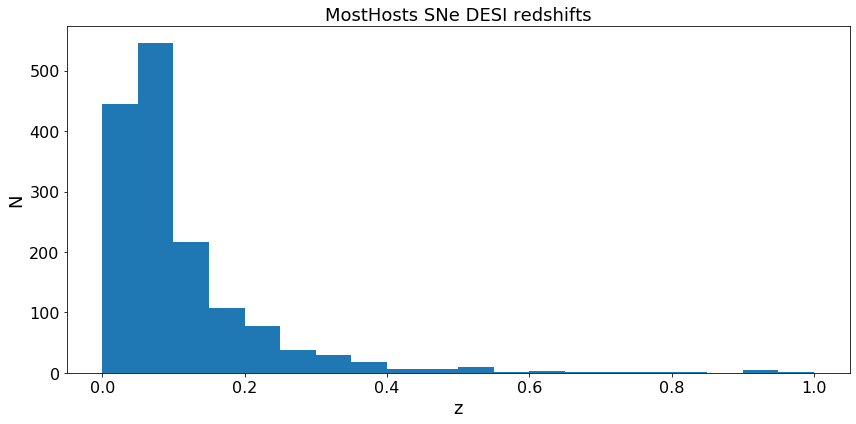

In [4]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
# fig.tight_layout()
fig.show()
fig.savefig( 'mosthostsz.svg' )
